In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os 
import natsort
import cv2
from PIL import Image
import matplotlib.pyplot as plt


# Introduction
This file is going to test the trained model on a custom dataset. The custom images are stored while using `tracker.py`. Each letter has 3 images to be tested on. 

# Load Dataset

### Define class labels A~Z, the first member here is meaningless

In [2]:
classes = []
classes.append(chr(48))
for i in range(65, 91):
    classes.append(chr(i))
class_size = len(classes)

# 26 letters 
display(np.transpose(classes))
print("class size = ", class_size)

array(['0', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
       'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
       'Z'], dtype='<U1')

class size =  27


### Helper class for visializing dataset

In [3]:
def display_batch(img, labels, n_row=5, n_col=6):
    """ Helper function for displaying one batch of images.
    The default batch size is 26.
    
        Args:
            img: one batch of images
            labels: ground truth or predicted label of images 
            n_row: number of rows of subplots
            n_col: number of columns of subplots
    """
    fig, ax = plt.subplots(n_row,n_col, figsize=(5,5))
    fig.tight_layout(pad=0.1)
    row = 0
    for i, img in enumerate(images):
        if i%n_col == 0 and i > 0:
            row += 1
            
        # EMNIST dataset is mirroed and rotated
        # convert the images back to regular view
        npimg = img.numpy()
        npimg = np.fliplr(npimg)
        npimg = np.rot90(npimg, axes=(-1,-2))
        npimg = np.transpose(npimg, (1, 2, 0))
        
        # configure into subplots
        sub_plot = ax[row, i%n_col]
        sub_plot.imshow(npimg)
        sub_plot.title.set_text(classes[labels[i]])
        # disable xy axis to make room for labels
        sub_plot.get_xaxis().set_visible(False)
        sub_plot.get_yaxis().set_visible(False)
        
    for i in range(n_row*n_col-len(labels), n_row*n_col):
        # remove unused blocks
        sub_plot = ax[row, i%n_col]
        sub_plot.set_axis_off()
        
    plt.show()

### Construct custom dataset loader

In [4]:
class UserKnownImageDataSet(Dataset):
    """ Helper class to load a dateset from a given path at `root_dit` 

        Args: 
            root_dir: root directory of labeled images.
                    image file names should be in format <index>_<label>_<random_string>.png
            transform: transform to images
    """
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.all_imgs = os.listdir(root_dir)
        self.total_imgs = natsort.natsorted(self.all_imgs)
        self.classes = [chr(i) for i in range(64,91)] 

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        for filename in self.all_imgs:
            if filename.split('_')[0] == str(idx):
                path = os.path.join(self.root_dir, filename)
                image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                image = np.rot90(image, axes=(0,1))
                image = cv2.resize(image, (28,28))
                image = Image.fromarray(image)
                image = self.transform(image)

                label = filename.split('_')[1]

                return image, torch.tensor(self.classes.index(label))


### Test loader
The transforms to dataset is the same as the transforms for training (see to `Pytorch_Training.ipynb`)

In [6]:
transform = transforms.Compose(
                    [transforms.ToTensor(),
                    transforms.Resize(28),
                    transforms.Normalize((0.5), (0.5))])

In [20]:
img_folder_path = './code/user_dataset'

batch_size = class_size-1
user_dataset = UserKnownImageDataSet(img_folder_path, transform=transform)
user_loader = DataLoader(user_dataset , batch_size=batch_size, shuffle=True, num_workers=0)

In [21]:
print("Size of dataset = ", len(user_dataset))

Size of dataset =  179


Gound Truth


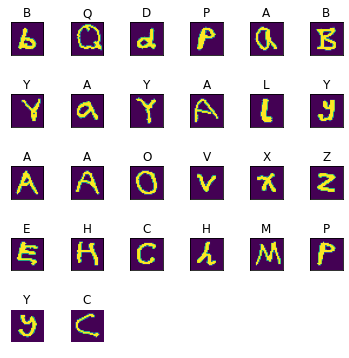

In [22]:
dataiter = iter(user_loader)
images, labels = dataiter.next()

print("Gound Truth")
display_batch(images, labels)

# Test Custom Dataset

### Load trained model
The model needs to be the same as training model (see to `Pytorch_Training.ipynb`)

In [23]:
class Net(nn.Module):
    """ Neural network for training and classifiying EMNIST dataset.

        Network architecture:
        - max pooling
        - 2D convolution layer of 64 channels and kernal size 5
        - 2D convolution layer of 128 channels and kernal size 5
        - Input layer
        - First hidden layer: fully connected layer of size 128 nodes
        - Second hidden layer: fully connected layer of size 64 nodes
        - Output layer: a linear layer with one node per class 

        Activation function: ReLU for all layers
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, class_size)

    def forward(self, x):
        self.pool = nn.MaxPool2d(2, 2)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [24]:
PATH = './model_letters.pth'
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Test model on one batch

Gound Truth


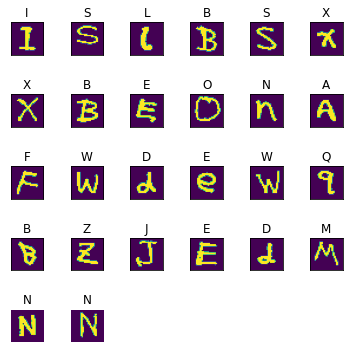

In [25]:
dataiter = iter(user_loader)
images, labels = dataiter.next()

print("Gound Truth")
display_batch(images, labels)

Predicted


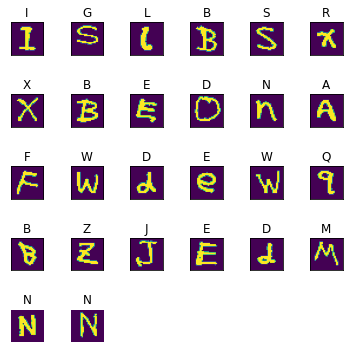

In [26]:
outputs = net(images.float())
_, predicted = torch.max(outputs, 1)

print("Predicted")
display_batch(images, predicted)

### Test model on entire dataset

In [27]:
def test(model, data_loader, device=torch.device('cpu')):
    """ Helper function for evaluating a trained neural network on a testing set.
    
        Args:
            model: trained neural network
            data_loader: for loading the netowrk input and targets from the testing or validation dataset
            device: device used when training, default is CPU

        Returns:
            test_loss: average loss value on the entire testing dataset
            test_accuracy: percentage of correctly classified samples in the testing or validation dataset
    """
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    test_loss = running_loss / total
    test_accuracy = correct * 100 / total

    return test_loss, test_accuracy

In [28]:
test_loss, test_accuracy = test(net, user_loader)
print("Test loss = ", test_loss)
print("Overall test accuracy = ", test_accuracy)

TypeError: object of type 'NoneType' has no len()

### Test accuracy on each label

In [ ]:
def test_each_label(model, data_loader, device=torch.device('cpu')):
    """ Helper function for evaluating a trained neural network on a testing set.
    
        Args:
            model: trained neural network
            data_loader: for loading the netowrk input and targets from the testing dataset
            device: device used when training, default is CPU

        Returns:
            test_loss: average loss value on the entire testing dataset
            test_accuracy: percentage of correctly classified samples in the testing dataset
    """
    class_correct = np.zeros(class_size)
    class_total = np.zeros(class_size)
    class_acc = np.zeros(class_size)
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images.float())
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(labels.size()[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(class_size):
        if class_total[i] > 0:
            class_acc[i] = 100 * class_correct[i]/class_total[i]
            print(classes[i], " class total = ", class_total[i], " --- correct = ", class_correct[i])
    
    return class_acc

In [ ]:
class_acc = test_each_label(net, user_loader)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(classes,class_acc)
ax.set_title("Accuracy (%) of each class")
fig.savefig("user_input_test.jpg", bbox_inches='tight')
plt.show()